In [0]:
# mount della cartella di Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# unzip data e clean
!unzip -a "drive/My Drive/data.zip" -d "dataset1"
!rm -rf image-dataset/__MACOSX # rimuovo una cartella inutile creata con lo zip

Archive:  drive/My Drive/data.zip
  inflating: dataset1/TrayDataset/TrayDataset/XTest/1005a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/2002a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/3004a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/4003a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/5006a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/6004a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/7010a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/8006a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a01.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a02.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a03.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a04.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a05.jpg  [binary]
  inflating: da

In [0]:
# installazione libreria utility
!pip install -U segmentation-models

In [0]:
#%tensorflow_version 1.x
import pandas as pd
import numpy as np
from numpy.random import uniform
import segmentation_models as sm
import matplotlib.pyplot as plt
import scipy.io as sio
from imageio import imread
from os import listdir
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
import cv2
from keras import backend as K
import keras

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
background=[0,0,0]
tray=[1,1,1]
cutler=[2,2,2]
form=[3,3,3]
straw=[4,4,4]
meatball=[5,5,5]
beef=[6,6,6]
roastlamb=[7,7,7]
beeftomatocasserole=[8,8,8]
ham=[9,9,9]
bean=[10,10,10]
cucumber=[11,11,11]
leaf=[12,12,12]
tomato=[13,13,13]
boiledrice=[14,14,14]
beefmexicanmeatballs=[15,15,15]
spinachandpumpkinrisotto=[16,16,16]
bakedfish=[17,17,17]
gravy=[18,18,18]
zucchini=[19,19,19]
carrot=[20,20,20]
broccoli=[21,21,21]
pumpkin=[22,22,22]
celery=[23,23,23]
sandwich=[24,24,24]
sidesalad=[25,25,25]
tartaresauce=[26,26,26]
jacketpotato=[27,27,27]
creamedpotato=[28,28,28]
bread=[29,29,29]
margarine=[30,30,30]
soup=[31,31,31]
apple=[32,32,32]
cannedfruit=[33,33,33]
milk=[34,34,34]
vanillayogurt=[35,35,35]
jelly=[36,36,36]
custard=[37,37,37]
lemonsponge=[38,38,38]
juice=[39,39,39]
applejuice=[40,40,40]
orangejuice=[41,41,41]
water=[42,42,42]

# We dont want to classify unlabelled.it will only make our dataset more unbalanced than it already is
label_values = [background,tray,cutler,form,straw,meatball,beef,roastlamb,beeftomatocasserole,ham,bean,cucumber,leaf,tomato,boiledrice,
beefmexicanmeatballs,spinachandpumpkinrisotto,bakedfish,gravy,zucchini,carrot,broccoli,pumpkin,celery,sandwich,sidesalad,
tartaresauce,jacketpotato,creamedpotato,bread,margarine,soup,apple,cannedfruit,milk,vanillayogurt,jelly,custard,lemonsponge,
juice,applejuice,orangejuice,water]

In [0]:
path = './dataset1/'
# Definizione backbone, caricamento IO, e preprocess dell'input
BACKBONE = 'vgg19'
#preprocess_input = sm.get_preprocessing(BACKBONE) # attenzione, non utilizzata -> da problemi!

# load your data
x_train_val = []
for image in listdir(path+'TrayDataset/TrayDataset/XTrain/'):
    x_train_val.append((image,cv2.resize(imread(path+'TrayDataset/TrayDataset/XTrain/'+image),(384,240),interpolation = cv2.INTER_AREA),image[0]))
                                       
y_train_val =[]
for image in listdir(path+'TrayDataset/TrayDataset/yTrain/'):
    y_train_val.append((image,cv2.resize(imread(path+'TrayDataset/TrayDataset/yTrain/'+image),(384,240),interpolation = cv2.INTER_AREA),image[0]))


#print(x_train_val[0])   

In [0]:
# ordino i due vettori e ricontrollo
x_train_val.sort(key = lambda x: x[0])
y_train_val.sort(key = lambda x: x[0])
x_Train_Val = [i[1] for i in x_train_val]
y_Train_Val = [i[1] for i in y_train_val]


# mi prendo i label per fare una stratificazione
x_label = [i[2] for i in x_train_val]

del x_train_val
del y_train_val
# riduco in 0-1

x_Train_Val = np.array(x_Train_Val)
# splitto in training e validation -> aggiunta stratificazione sul label elemento[0] del nome img
X_train, X_val, y_train, y_val = train_test_split(x_Train_Val, y_Train_Val, test_size=0.25, random_state=17, stratify = x_label)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [0]:
# verifico la dimensione del X_train e X_val
print(str(X_train.shape)+ ' '+ str(X_val.shape)+' '+str(type(X_train)))

(930, 240, 384, 3) (311, 240, 384, 3) <class 'numpy.ndarray'>


In [0]:
def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    #print('Start One-Hot Vectorizing...')
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    #print('Done..')
    return semantic_map

In [0]:
def equalize_hist(img):
    """Normalize each channel of the picture
    # Arguments 
        img : 3D array
    
    # Return Normalized img"""
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])

    return img

In [0]:
def median_frequency_balancing(image_files, num_classes=len(label_values)):
    label_to_frequency_dict = {}
    for i in range(num_classes):
        label_to_frequency_dict[i] = []

    for n in range(image_files.shape[0]):
        image = image_files[n]

        #For each image sum up the frequency of each label in that image and append to the dictionary if frequency is positive.
        for i in range(num_classes):
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            if class_frequency != 0.0:
                label_to_frequency_dict[i].append(class_frequency)

    class_weights = []

    #Get the total pixels to calculate total_frequency later
    total_pixels = 0
    for frequencies in label_to_frequency_dict.values():
        total_pixels += sum(frequencies)

    for i, j in label_to_frequency_dict.items():
        j = sorted(j) #To obtain the median, we got to sort the frequencies

        median_frequency = np.median(j) / sum(j)
        total_frequency = sum(j) / total_pixels
        median_frequency_balanced = median_frequency / total_frequency
        class_weights.append(median_frequency_balanced)

    #Set the last class_weight to 0.0 as it's the background class
#     class_weights[-1] = 0.0

    return class_weights

In [0]:
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [0]:
#X_train = [equalize_hist(X_train[i]) for i in range(len(X_train))]
#X_val = [equalize_hist(X_val[i]) for i in range(len(X_val))]


X_train=np.array(X_train).astype('float32')/255
X_val=np.array(X_val).astype('float32')/255
#todo togliere commento in train qui
y_train_norm = np.array([one_hot_it(y_train[i],label_values) for i in range(len(y_train))])
del y_train
y_val_norm = np.array([one_hot_it(y_val[i],label_values) for i in range(len(y_val))])
del y_val

In [0]:
#X_oh = reverse_one_hot(y_train)
#weights = median_frequency_balancing(X_oh)


In [0]:
###### definizione loss e iou
def iou_coef(y_true, y_pred, smooth=1):
 intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
 union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
 iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
 return iou

# IoU = (|X &amp; Y|)/ (|X or Y|)
def iou_coef_loss(y_true, y_pred):
 return -iou_coef(y_true, y_pred)

In [0]:
# ricerca hpam <-> Coarse to fine classica
COARSE_TRAIN_EPOCHS = 10
FINER_TRAIN_EPOCHS = 20 # chiamato epochs dopo
MAX_RANGE = 20
for i in range(0,MAX_RANGE):
  lr = 10**uniform(-3, -2) # COARSE TO FINE [COARSE] => NEW INTERVAL: -3, -2 <-> OLD INTERVAL : -7 -1 
  # lr = ... # FINER 
  adam = Adam(learning_rate = lr)
  model = sm.PSPNet(BACKBONE, encoder_weights='imagenet', input_shape = (240,384,3), encoder_freeze = True, classes=43, activation='softmax')
  model.compile(
    adam,
    #loss=sm.losses.JaccardLoss(), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',iou_coef]
    )
  if i == 0:
    print(model.summary()) # model.summary() non visualizzo sempre per comodità 
  print('********** lr = '+str(lr)+' **********')
  model.fit(
      x=X_train,
      y=y_train_norm,
      batch_size=16,
      epochs=COARSE_TRAIN_EPOCHS,
      validation_data=(X_val,y_val_norm))

80142336/80134624 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 384, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 240, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 240, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 120, 192, 64) 0           block1_conv2[0][0]               
___________________________

In [0]:
#checkpoint per salvare il modello quando l'accuracy sul validation è max
filepath = "/content/drive/My Drive/gimmi3"
checkpoint = keras.callbacks.ModelCheckpoint(filepath,save_weights_only=False,monitor='val_iou_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
# fit model <-> LONG Time If needed
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
EPOCHS = 20
# lr = ... default attualmente
meanIOU = tf.keras.metrics.MeanIoU(num_classes=43)
lr2 = 0.002771462109359584
adam = Adam(learning_rate=lr2)
model = sm.PSPNet(BACKBONE, encoder_weights='imagenet', input_shape = (240,384,3), encoder_freeze = True, classes=43, activation='softmax')
model.compile(
    adam,
    #loss=sm.losses.JaccardLoss(), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',meanIOU,iou_coef] # metrics=[sm.metrics.iou_score]
    )
model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 384, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 240, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 240, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 120, 192, 64) 0           block1_conv2[0][0]               
___________________________

In [0]:
model.fit(
   x=X_train,
   y=y_train_norm,
   batch_size=16,
   epochs=50,
   validation_data=(X_val,y_val_norm),
   verbose=1,
   callbacks=callbacks_list)

Train on 930 samples, validate on 311 samples
Epoch 1/50
930/930 [==============================] - 61s 66ms/step - loss: 0.5859 - accuracy: 0.8668 - mean_io_u: 0.4982 - iou_coef: 0.7052 - val_loss: 1.8545 - val_accuracy: 0.7170 - val_mean_io_u: 0.5438 - val_iou_coef: 0.5600

Epoch 00001: val_iou_coef improved from -inf to 0.56005, saving model to /content/drive/My Drive/gimmi3
Epoch 2/50
930/930 [==============================] - 52s 55ms/step - loss: 0.2043 - accuracy: 0.9494 - mean_io_u: 0.5596 - iou_coef: 0.8466 - val_loss: 0.3985 - val_accuracy: 0.9035 - val_mean_io_u: 0.5672 - val_iou_coef: 0.7932

Epoch 00002: val_iou_coef improved from 0.56005 to 0.79318, saving model to /content/drive/My Drive/gimmi3
Epoch 3/50
930/930 [==============================] - 51s 55ms/step - loss: 0.1609 - accuracy: 0.9611 - mean_io_u: 0.5739 - iou_coef: 0.8779 - val_loss: 0.1686 - val_accuracy: 0.9583 - val_mean_io_u: 0.5733 - val_iou_coef: 0.8775

Epoch 00003: val_iou_coef improved from 0.79318 to

In [0]:
model.save('./psp-Vgg19jc.h5')

In [0]:
model.save('./drive/My Drive/gimmi')

In [0]:
from keras.models import load_model
model=load_model('./drive/My Drive/gimmi',compile=False)
model.compile(
    adam,
    #loss=sm.losses.JaccardLoss(), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',meanIOU,iou_coef] # metrics=[sm.metrics.iou_score]
    )


In [0]:
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values
        
    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [0]:
def plot_predictions(X_test,preds,path):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
    ax[0].imshow(X_test,aspect="auto")
    ax[0].set_title("Input")
    ax[1].imshow(preds, aspect="auto")
    ax[1].set_title("Prediction")
    fig.tight_layout()

In [0]:
#Make predictions
y_prob = model.predict(X_val)
#Make prediction in correct dimension
y_prob_r = []
for i in range (0,y_prob.shape[0]):
  y_prob_r.append(cv2.resize(y_prob[i],(416,256),interpolation = cv2.INTER_AREA))
  
y_prob_r = np.array(y_prob_r)
print(y_prob_r.shape)

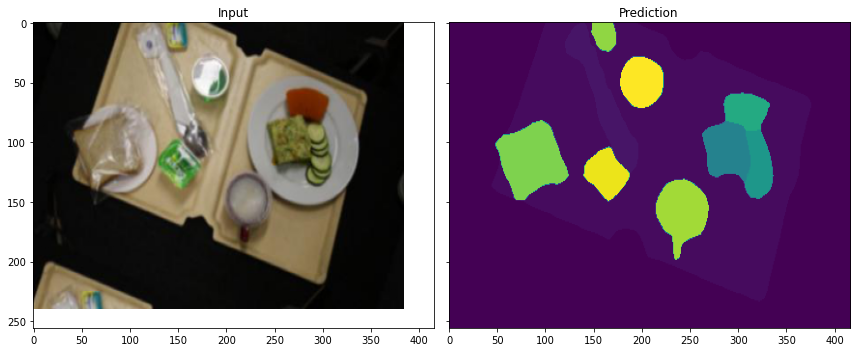

In [0]:
#Output the most probable classes based on predictions
#puoi cambiare y_prob_r con y_prob per avere l'output in dimensioni della rete
y_classes = y_prob_r.argmax(axis=-1)

#Reshape our classes in order to proceed with visualizing our predictions
#Cambiare dim qui se volgio ottenere dim della rete
y_classes = y_classes.reshape(y_classes.shape[0],256,416).astype('int')

#segment = colour_code_segmentation(y_classes,label_values) per mettere stesso colore di partenza
#segment=np.squeeze(segment,axis=3)
plot_predictions(X_val[2],y_classes[2],path="3")

In [0]:
plot_predictions(X_val[1],y_classes[1],path="3")

**RICARICO LE Y IN DIMENSIONI ORIGINALI PER CONFRONTO**

In [0]:
path = './dataset1/'
# load your data
x_train_val2 = []
for image in listdir(path+'TrayDataset/TrayDataset/XTrain/'):
    x_train_val2.append((image,imread(path+'TrayDataset/TrayDataset/XTrain/'+image),image[0]))
                                       
y_train_val2 =[]
for image in listdir(path+'TrayDataset/TrayDataset/yTrain/'):
    y_train_val2.append((image,imread(path+'TrayDataset/TrayDataset/yTrain/'+image),image[0]))


In [0]:
# ordino i due vettori e ricontrollo
x_train_val2.sort(key = lambda x: x[0])
y_train_val2.sort(key = lambda x: x[0])
x_Train_Val = [i[1] for i in x_train_val2]
y_Train_Val = [i[1] for i in y_train_val2]


# mi prendo i label per fare una stratificazione
x_label = [i[2] for i in x_train_val2]

del x_train_val2
del y_train_val2
# riduco in 0-1

x_Train_Val = np.array(x_Train_Val)
# splitto in training e validation -> aggiunta stratificazione sul label elemento[0] del nome img
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_Train_Val, y_Train_Val, test_size=0.25, random_state=17, stratify = x_label)
X_train2 = np.array(X_train2)
X_val2 = np.array(X_val2)
y_train2 = np.array(y_train2)
y_val2 = np.array(y_val2)

**CALCOLA ACCURACY DOPO INTERP**

In [0]:
y_val2=y_val2[:,:,:,0]
a=y_val2.flatten()
b=y_classes.flatten()

#VALUTAZIONE ACCURACY
def categorical_accuracy(y_true, y_pred):
  return K.cast(K.equal(y_true, y_pred), K.floatx())

In [0]:
accuracy = categorical_accuracy(a, b)
print(K.sum(accuracy)/33120256)

tf.Tensor(0.9815942, shape=(), dtype=float32)
